# structid

This notebook demonstrates the basic usage of the `structid` package for structural analysis of molecular dynamics trajectories.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

# Import structid components
from structid import FrameAccumulator
from structid.descriptors import SteinhardtDescriptor
from structid.detectors import StdDevDetector, GPRDetector
from structid.plotting import plot_descriptor_distances

import pyscal3.core as psc

In [63]:
trajectory = read('ts-fcc-solid-1200-0/traj.ts.forward_1.dat', ':')

In [64]:
def get_descriptor_vector(frame, l_values, cutoff):
    # Convert ASE Atoms to pyscal System        
    system = psc.System(frame, format="ase")
    system.find.neighbors(method="cutoff", cutoff=cutoff)

    # Calculate Steinhardt parameters (returns list aligned with l_values)
    q_list = system.calculate.steinhardt_parameter(l_values, averaged=True)

    # Create feature vector: mean q_l for each l value
    frame_vector = [np.mean(q_list[i]) for i in range(len(l_values))]
    return frame_vector

In [65]:
q_values = []
for frame in trajectory:
    q_vector = get_descriptor_vector(frame, l_values=[5, 6, 8, 10], cutoff=0)
    q_values.append(q_vector)

In [66]:
le = 1200/2000
le

0.6

In [69]:
larr = np.linspace(1, le, len(q_values))
Tarr = 1200/larr

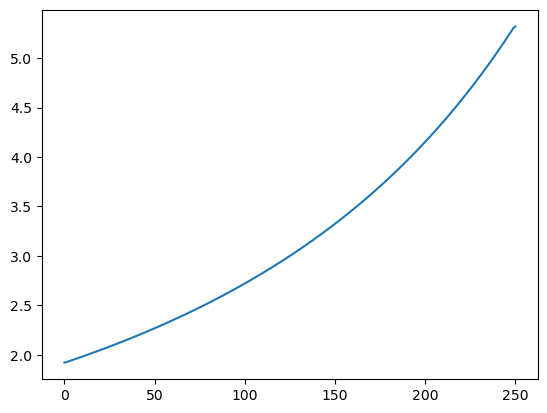

In [71]:
plt.plot(np.gradient(Tarr))

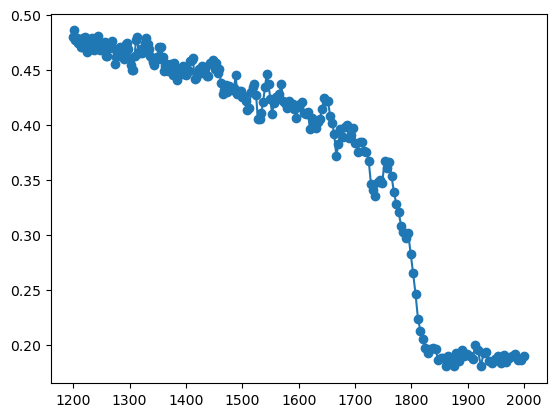

In [68]:
#plt.plot( np.array(q_values)[:,0])
#plt.plot(Tarr, np.array(q_values)[:,0], 'o-')
plt.plot(Tarr, np.array(q_values)[:,1], 'o-')
#plt.plot(Tarr, np.gradient(np.array(q_values)[:,0], Tarr))
#plt.plot( np.array(q_values)[:,2])
#plt.plot( np.array(q_values)[:,3])

In [60]:
import numpy as np
from dataclasses import dataclass


@dataclass
class TransitionEvent:
    detected: bool
    score: float
    frame: int
    T: float
    details: dict

import numpy as np

class OnlineSlopeChangeDetector:
    def __init__(
        self,
        alpha_fast=0.3,
        alpha_slow=0.02,
        slope_threshold=4.0,
        persistence=20,
        warmup=20,
        init_var=1e-6,
        eps=1e-12,
    ):
        self.alpha_f = alpha_fast
        self.alpha_s = alpha_slow
        self.slope_threshold = slope_threshold
        self.persistence = persistence
        self.warmup = warmup
        self.eps = eps

        self.prev_T = None
        self.prev_q = None

        self.slope_fast = None
        self.slope_slow = None
        self.var = init_var

        self.frame = 0
        self.counter = 0
        self.triggered = False

    def update(self, T, q):
        if self.prev_T is None:
            self.prev_T = T
            self.prev_q = q
            return False, 0.0

        dT = T - self.prev_T
        if abs(dT) < self.eps:
            return False, 0.0

        slope = (q - self.prev_q) / dT

        # --- bootstrap on first slope ---
        if self.slope_fast is None:
            self.slope_fast = slope
            self.slope_slow = slope
            self.prev_T = T
            self.prev_q = q
            self.frame += 1
            return False, 0.0

        # --- EWMA updates ---
        self.slope_fast = (
            self.alpha_f * slope + (1 - self.alpha_f) * self.slope_fast
        )
        self.slope_slow = (
            self.alpha_s * slope + (1 - self.alpha_s) * self.slope_slow
        )

        diff = self.slope_fast - self.slope_slow

        # update variance of diff (never let it collapse to zero)
        self.var = 0.99 * self.var + 0.01 * diff * diff
        self.var = max(self.var, self.eps)

        score = abs(diff) / np.sqrt(self.var)

        self.frame += 1
        detected = False

        if self.frame > self.warmup:
            if score > self.slope_threshold:
                self.counter += 1
            else:
                self.counter = 0

            if self.counter >= self.persistence and not self.triggered:
                detected = True
                self.triggered = True

        self.prev_T = T
        self.prev_q = q

        return detected, score

In [61]:

det = OnlineSlopeChangeDetector(
    alpha_fast=0.2,
    alpha_slow=0.01,
    slope_threshold=4.0,
    persistence=15,
)

for k in range(len(Tarr)):
    ev, score = det.update(Tarr[k], q_values[k][3])
    print(f"frame {k}, T={Tarr[k]}, score={score:.2f}")
    if ev:
        print(f"Transition detected at frame {k}, T={Tarr[k]}, score={score:.2f}")
        break

frame 0, T=1200.0, score=0.00
frame 1, T=1201.923076923077, score=0.00
frame 2, T=1203.852327447833, score=0.63
frame 3, T=1205.7877813504824, score=0.21
frame 4, T=1207.7294685990337, score=1.06
frame 5, T=1209.6774193548388, score=1.43
frame 6, T=1211.631663974152, score=1.04
frame 7, T=1213.5922330097087, score=0.59
frame 8, T=1215.5591572123178, score=0.54
frame 9, T=1217.5324675324675, score=1.53
frame 10, T=1219.5121951219512, score=1.59
frame 11, T=1221.4983713355048, score=1.56
frame 12, T=1223.4910277324632, score=1.65
frame 13, T=1225.4901960784314, score=1.18
frame 14, T=1227.495908346972, score=0.65
frame 15, T=1229.5081967213116, score=1.10
frame 16, T=1231.527093596059, score=0.93
frame 17, T=1233.5526315789473, score=0.53
frame 18, T=1235.5848434925865, score=0.58
frame 19, T=1237.6237623762377, score=1.07
frame 20, T=1239.6694214876034, score=1.04
frame 21, T=1241.7218543046358, score=1.18
frame 22, T=1243.7810945273632, score=1.13
frame 23, T=1245.8471760797343, score=

In [22]:
#first make a descriptor
descriptor = SteinhardtDescriptor(l_values=[6], cutoff=0)

#now make a detector
detector = StdDevDetector()

#finally an accumulator
accumulator = FrameAccumulator(descriptor=descriptor, 
                               detector=detector)

In [23]:

# Process trajectory
for idx, atoms in enumerate(trajectory):
    is_consistent = accumulator.calculate_single_frame(atoms)
    if not is_consistent:
        print(f"  ⚠️  Structural change detected at frame {idx}")

  ⚠️  Structural change detected at frame 110
  ⚠️  Structural change detected at frame 122
  ⚠️  Structural change detected at frame 148
  ⚠️  Structural change detected at frame 220
  ⚠️  Structural change detected at frame 221
  ⚠️  Structural change detected at frame 224


In [ ]:
accumulator.